## Loads Model, Obtains Predictions, Writes Files, Useful Code Bits

In [8]:
%load_ext autoreload
%autoreload 2

import os
os.chdir('..')
os.environ['CUDA_VISIBLE_DEVICES']='0,1'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database',)).History will not be written to the database.


In [9]:
# Set checkpoint path
checkpoint_path = '/lfs/local/0/jdunnmon/repos/pytorch-classification/checkpoints/cifar100/resnext-8x64d-epochs300-superclass-correct-val'

In [3]:
from analysis.analysis_utils import load_trained_model, fetch_dataloaders
import models.cifar as models

# Loading models 
ind_to_class = {}
class_to_ind = {}

# Optional subsampling/whitening/blurring
subsample_subclass = {}
whiten_subclass = {}
diff_subclass = {}

# Loading trained model
trained_model, args = load_trained_model(checkpoint_path)
dataloaders = fetch_dataloaders(args, subsample_subclass=subsample_subclass, whiten_subclass=whiten_subclass)

# Getting class-to-index maps for CIFAR100
class_to_ind['super'] = dataloaders['test'].dataset.class_to_idx
class_to_ind['sub'] = dataloaders['test'].dataset.fine_class_to_idx

for tp in ['super','sub']:
    ind_to_class[tp] = {v:k for k,v in class_to_ind[tp].items()}

/lfs/raiders2/0/jdunnmon/repos/pytorch-classification/models/cifar/resnext.py:81: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  init.kaiming_normal(self.classifier.weight)
/lfs/raiders2/0/jdunnmon/repos/pytorch-classification/models/cifar/resnext.py:86: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  init.kaiming_normal(self.state_dict()[key], mode='fan_out')


Using 20 classes...
Files already downloaded and verified
Using coarse labels...
Using coarse labels...


In [6]:
import torch

# Setting cuda
# NOTE: only works for cuda == True for now
use_cuda = True
testloader = dataloaders['test']
if use_cuda:
    trained_model.cuda()
else:
    trained_model.to('cpu')
    trained_model.module.to('cpu')

In [7]:
import numpy as np
from analysis.analysis_utils import extract_resnext_features

filenames_all = []
coarse_labels_all = []
fine_labels_all = []
fine_preds_all = []
preds_all = []
losses_all = []
softmax_all = []
features_all = []

for batch_idx, (inputs, targets, coarse_labels, fine_labels, filenames) in enumerate(testloader):

    if use_cuda:
        inputs, targets = inputs.cuda(), targets.cuda()
    else:
        inputs, targets = inputs.cpu(), targets.cpu()
    inputs, targets = torch.autograd.Variable(inputs, volatile=True), torch.autograd.Variable(targets)

    # Compute output
    outputs = trained_model(inputs)
    _, preds = outputs.topk(1, 1, True, True)
    soft = torch.nn.Softmax()(outputs)
    feats = extract_resnext_features(trained_model,inputs)
    
    # Record outputs of interest
    coarse_labels_all+=list([int(a) for a in coarse_labels])
    fine_labels_all+=list([int(a) for a in fine_labels])
    preds_all+=list([int(a) for a in preds])
    softmax_all+=list([a.detach().cpu().numpy() for a in soft])
    features_all+=list([a.detach().cpu().numpy() for a in feats])
    filenames_all+=list(filenames)

/lfs/local/0/jdunnmon/repos/anaconda3/envs/pytorch-classification/lib/python3.6/site-packages/ipykernel_launcher.py:19: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
/lfs/local/0/jdunnmon/repos/anaconda3/envs/pytorch-classification/lib/python3.6/site-packages/ipykernel_launcher.py:24: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


In [8]:
# Creating prediction dataframe for writing
preds_dict = {
    'filename':filenames_all,
    'fine_labels':fine_labels_all,
    'coarse_labels':coarse_labels_all,
    'preds':preds_all,
    'fine_labels_string': [ind_to_class['sub'][a] for a in fine_labels_all],
    'coarse_labels_string': [ind_to_class['super'][a] for a in coarse_labels_all],
    'features':features_all,
    'softmax':softmax_all,
}
prediction_df = pd.DataFrame(preds_dict)

In [11]:
# Writing prediction dataframe
#prediction_df.to_csv(f"{checkpoint_path}/predictions.tsv",sep='\t')

# Writing prediction pickle
import pickle
#with open(f"{checkpoint_path}/predictions.pkl",'wb') as fl:
#    pickle.dump(preds_dict,fl)
with open(f"{checkpoint_path}/predictions.pkl",'rb') as fl:
    preds_dict = pickle.load(fl)

In [12]:
import pandas as pd
prediction_df = pd.DataFrame(preds_dict)

In [13]:
# Getting coarse class accuracies
from analysis.analysis_utils import get_coarse_accuracies
coarse_results = get_coarse_accuracies(prediction_df)

large_natural_outdoor_scenes superclass coarse label accuracy: 0.87
mountain subclass coarse label accuracy: 0.9
forest subclass coarse label accuracy: 0.66
sea subclass coarse label accuracy: 0.92
cloud subclass coarse label accuracy: 0.94
plain subclass coarse label accuracy: 0.93


aquatic_mammals superclass coarse label accuracy: 0.688
seal subclass coarse label accuracy: 0.65
beaver subclass coarse label accuracy: 0.61
whale subclass coarse label accuracy: 0.75
dolphin subclass coarse label accuracy: 0.78
otter subclass coarse label accuracy: 0.65


fruit_and_vegetables superclass coarse label accuracy: 0.872
mushroom subclass coarse label accuracy: 0.69
apple subclass coarse label accuracy: 0.96
orange subclass coarse label accuracy: 0.98
pear subclass coarse label accuracy: 0.91
sweet_pepper subclass coarse label accuracy: 0.82


flowers superclass coarse label accuracy: 0.904
tulip subclass coarse label accuracy: 0.96
rose subclass coarse label accuracy: 0.85
sunflower subclass

In [14]:
# Melting dataframe for plotting
plot_df = pd.DataFrame(coarse_results).reset_index()
plot_df = plot_df.rename(columns={"index": "Superclass"})
plot_df = plot_df.melt(id_vars=['Superclass'], var_name='Subset', value_name='Accuracy')

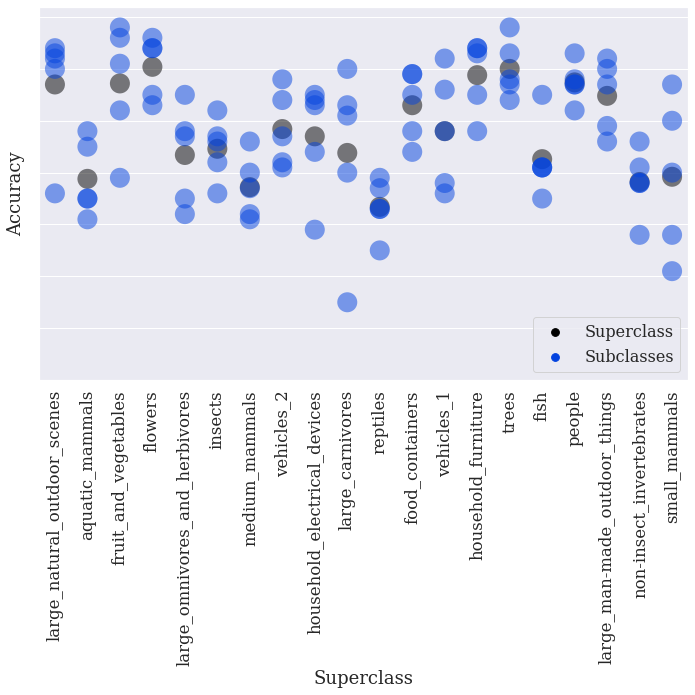

In [64]:
import seaborn as sns
sns.set(font_scale=1.2) 
sns.set_style("whitegrid")
sns.set_style({'font.family':'serif'})
import matplotlib.font_manager as font_manager

font = font_manager.FontProperties(family='Dejavu Serif',
                                   style='normal', size=16)
plt.rcParams.update({'font.family': 'serif'})

palette = [sns.xkcd_rgb["black"]] + 5*[sns.xkcd_rgb["blue"]]
sns.set(font_scale=1.5)
f = plt.figure(figsize=(10,10))
ax = sns.stripplot(x="Superclass", y="Accuracy", hue="Subset", data=plot_df, jitter=False, s=20, palette=palette, alpha=0.5)
ax.set_xticklabels(ax.get_xticklabels(),rotation=90,fontdict={'family':'Dejavu Serif'})
ax.set_yticklabels(ax.get_yticklabels(),fontdict={'family':'Dejavu Serif'})
ax.set_xlabel(ax.get_xlabel(),fontdict={'family':'Dejavu Serif'})
ax.set_ylabel(ax.get_ylabel(),fontdict={'family':'Dejavu Serif'})
h,l = ax.get_legend_handles_labels()
l[1] = 'Subclasses'
l[0] = 'Superclass'
ax.legend_.remove()
ax.legend(h[0:2],l[0:2], ncol=1, loc='lower right',prop=font)
ax.set_ylim([0.3,1.02])
plt.tight_layout()
plt.savefig(f'{checkpoint_path}/Superclass-Subclass-CIFAR-100-Correct-Val-v3.png',format='png')
plt.show()

## SANDBOX

In [63]:
os.getcwd()

'/lfs/raiders2/0/jdunnmon/repos'

In [4]:
# Code for getting class-ti-ind map
ind_to_class['super']

{0: 'aquatic_mammals',
 1: 'fish',
 2: 'flowers',
 3: 'food_containers',
 4: 'fruit_and_vegetables',
 5: 'household_electrical_devices',
 6: 'household_furniture',
 7: 'insects',
 8: 'large_carnivores',
 9: 'large_man-made_outdoor_things',
 10: 'large_natural_outdoor_scenes',
 11: 'large_omnivores_and_herbivores',
 12: 'medium_mammals',
 13: 'non-insect_invertebrates',
 14: 'people',
 15: 'reptiles',
 16: 'small_mammals',
 17: 'trees',
 18: 'vehicles_1',
 19: 'vehicles_2'}

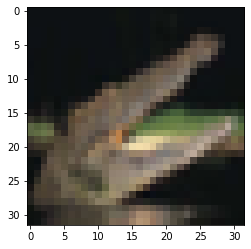

In [7]:
# Code for looking at images
import matplotlib.pyplot as plt
plt.imshow(dataloaders['test'].dataset.data['data'][112])

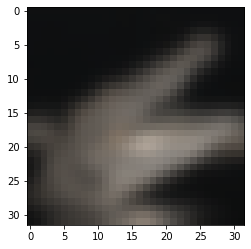

In [6]:
# Code for blurring images
from scipy.ndimage.filters import gaussian_filter
plt.imshow(gaussian_filter(dataloaders['test'].dataset.data['data'][112], sigma=1.25))

In [4]:
import pickle
# Code for opening metadata file
with open('data/cifar-100-python/meta','rb') as fl:
    test_set = pickle.load(fl, encoding='latin1')

In [12]:
import ast
# Code for literal evaluation of string arguments
ast.literal_eval(str({'mountain':0.25, "dolphin":0.25}))['mountain']

0.25

In [50]:
# Code for reading in saved pickle
import pickle
with open(f'{checkpoint_path}/predictions.pkl','rb') as fl:
    read_data = pickle.load(fl)
print(read_data.keys())
print(read_data['softmax'][0])
len(read_data['features'][0])

dict_keys(['filename', 'fine_labels', 'coarse_labels', 'preds', 'fine_labels_string', 'coarse_labels_string', 'features', 'softmax'])
[3.3991101e-01 2.0973168e-03 3.6208675e-04 9.9613890e-04 3.3064061e-04
 5.2186134e-03 2.6534460e-03 2.3685237e-02 1.6689739e-03 5.5116761e-01
 2.2342072e-03 8.3275707e-03 1.1668189e-03 6.2619844e-03 9.2053190e-03
 1.9119394e-03 2.9823640e-03 2.7749953e-03 3.5174839e-02 1.8689107e-03]


1024

In [16]:
# Code for reading in save tsv
import ast
aa = pd.read_csv(f'{checkpoint_path}/predictions.tsv', sep='\t', index_col=0)

# Need to do some odd replacement to reconstitute saved lists
softmax = ast.literal_eval(saved_pd['softmax'][0].replace(' ',','))
print(softmax)

features = ast.literal_eval(saved_pd['features'][0].replace(' ',','))
print(features)

Object `reset_index` not found.
